In [9]:
import finesse.virgo
from finesse.analysis.actions import FrequencyResponse, Xaxis

import numpy as np
import matplotlib.pyplot as plt

finesse.init_plotting()

Purpose of this notebook is to prepare and then compare getting the DARM TF via FrequencyResponse vs sgen/xaxis.

In [55]:
# prepare a pretuned Virgo model
# this is an old model that was tuned using zero_k00=True
virgo = finesse.virgo.Virgo('virgoKat_tuned.kat', zero_k00=True)

virgo.model.parse('''
# adding detectors needed for this kat file.
pd1 B4_112 B4_attenuator.p3.o f=2*eom56.f
mathd B4_112_mag abs(B4_112)

# add a new dof for the DARM tf
dof DARM_Fz NE.dofs.F_z -1 WE.dofs.F_z +1
''')

# make but do not switch to dc lock
virgo.make(dc_lock=False)

Adjusting recycling cavity lengths...
Pretuning...
Optimizing demodulation phases...
Optimizing lock gains...
Running RF locks...
Done.


To speed up the darm tf, we can make two modifications:

1. Use FrequencyResponse instead of xaxis since it is optimized for signal simulations.
2. Remove extra modulations to save computation since these will have no effect on the 56MHz signal.

## 1. FrequencyResponse

Create a new function using the `FrequencyResponse` action with the new `DARM_Fz` DOF.

In [59]:
def get_DARM_FR(base, dof='DARM_Fz', readout_port='B1p_56.I', axis=[0.5, 1000, 201]):
    model = base.deepcopy()
    
    model.parse('fsig(1)')

    return model.run(FrequencyResponse(
        np.geomspace(*axis),
        [dof],
        [readout_port]
    ))

def plot_DARM_sgen(base, dof='DARM_Fz', readout_port='B1p_56.I', axis=[0.5, 1000, 201]):
    out = get_DARM_sgen(base, axis)

    fig,axs = plt.subplots(2)

    axs[0].loglog(out.x1, np.abs(out['darm']), label=f'{readout_port} (abs)')
    axs[0].set_ylabel('Amplitude [$\sqrt{W}$]')
    axs[0].legend()

    axs[1].semilogx(out.x1, np.angle(out['darm'], deg=True))
    axs[1].set_ylabel('Phase [deg]')
    axs[1].set_xlabel('f [Hz]')

def get_DARM_sgen(base, axis=[0.5, 1000, 200]):
    model = base.deepcopy()

    model.parse("""
    fsig(1)

    # apply a signal to the end mirrors
    sgen sigQ NE.mech.F_z phase=180
    sgen sigI WE.mech.F_z

    # read the output after the SRC
    pd2 darm SRAR.p2.o f1=eom56.f phase1=B1p_56.phase f2=fsig.f phase2=none
    """
    )

    return model.run(Xaxis(model.fsig.f, "log", *axis))


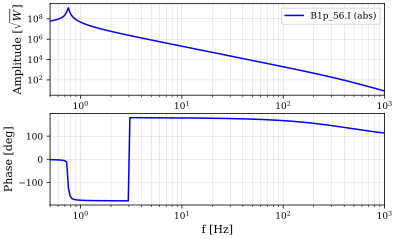

In [57]:
# plot the old DARM TF to show it is as expected
plot_DARM_sgen(virgo.model);

In [60]:
# get the darm tf using FR
new = get_DARM_FR(virgo.model)

In [61]:
# get the darm tf with sgen
old = get_DARM_sgen(virgo.model)

Text(0.5, 0, 'f [Hz]')

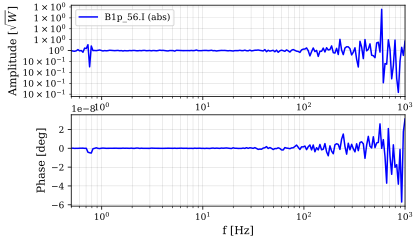

In [63]:
# ratio comparison of old/new to show they are the same
fig,axs = plt.subplots(2)

axs[0].loglog(new.f, np.abs(old['darm']/new['DARM_Fz', 'B1p_56.I']), label='B1p_56.I (abs)')
axs[0].set_ylabel('Amplitude [$\sqrt{W}$]')
axs[0].legend()

axs[1].semilogx(new.f, np.angle(old['darm']/new['DARM_Fz', 'B1p_56.I'], deg=True))
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('f [Hz]')

## Conclusion

Using `FrequencyResponse` is faster with equivalent results and should be used instead of `sgen`/`xaxis`.